In [7]:
import clease 
import numpy as np 

In [8]:
# set the seed
np.random.seed(42)

In [19]:
from clease.settings import Concentration 
conc = Concentration(basis_elements=[['Al', 'Cu']])

## Ways to set Concentration Limits

In [10]:
# ways to set concentration limits 
conc = Concentration(basis_elements=[['Al', 'Cu']], A_lb=[[2,0]],b_lb=[1]) # linear algebra way

In [11]:
#setting concentration limits using formula
conc = Concentration(basis_elements=[['Au', 'Cu']])
conc.set_conc_formula_unit(formulas=["Au<x>Cu<1-x>"], variable_range={"x": (0, 0.5)})

In [12]:
#setting concetration limits using a range
conc = Concentration(basis_elements=[['Au', 'Cu']])
conc.set_conc_ranges(ranges=[[(0, 0.5), (0.5, 1)]])

In [13]:
A_eq = [[1.0, -1.0]]
b_eq = [0.0]
conc = Concentration(basis_elements=[['Al', 'Cu']], A_eq=A_eq, b_eq=b_eq)

# forces the concentration to be equal
for i in range(10):
    x = conc.get_random_concentration([20])
    assert np.abs(x[0] - x[1]) < 1e-10

In [14]:
# here we fource the number of Al to be greater than 12 
A_lb = [[20, 0.0]]
b_lb = [12]
conc = Concentration(basis_elements=[['Al', 'Cu']], A_lb=A_lb, b_lb=b_lb)
for i in range(10):
    x = conc.get_random_concentration([20])
    assert round(20*x[0]) >= 12

In [15]:
# for a two sublattice system
basis_elements = [['Li', 'V'],['O','F']]

In [16]:
# this sets O to be twice that of F
A_eq = [[0.0, 0.0, -1.0, 2.0]]
b_eq = [0.0]
conc = Concentration(basis_elements=basis_elements, A_eq=A_eq, b_eq=b_eq)
for i in range(10):
    x = conc.get_random_concentration([18, 18])
    assert abs(x[2] - 2*x[3]) < 1e-10

In [18]:
# this sets the concentration of Li to be greater than 0.2 and O to be less than 0.7
A_lb = [[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, -1.0, 0.0]]
b_lb = [0.2, -0.7]
conc = Concentration(basis_elements=basis_elements, A_lb=A_lb, b_lb=b_lb)
for i in range(10):
   x = conc.get_random_concentration([18, 18])
   assert x[0] >= 0.2 and x[2] < 0.7

## Specifying CE Settings 

In [21]:
from clease.settings import CEBulk
settings = CEBulk(crystalstructure='fcc',
                  a=4.05,
                  size=[2,2,2],
                  supercell_factor = 64,
                  concentration=conc,
                  db_name = 'aucu.db',
                  max_cluster_dia=[6.0, 4.5, 4.5])

In [22]:
settings.view_clusters()

## Generating Initial Structures 

The generate_initial_pool generates one structure per composition, where the number of each constituing element is at a maximum/minimum. In the AuCu situation, the maximum and minimum are Au = 0, 1, and Cu = 0, 1 -- > Two structures are made, one with only Au and one with only Cu 

Since we set 10 structures, 8 additional structures will be made 

In [23]:
from clease.structgen import NewStructures

# generation_number helps you keep track of when you generated the structures 
ns = NewStructures(settings, generation_number=0,struct_per_gen=10)
ns.generate_initial_pool()

In [24]:
from ase.db import connect 
ns = NewStructures(settings, generation_number=0, struct_per_gen=10)

# get the template structure with cell size = 3x3x3
atoms = connect('aucu.db').get(id=10).toatoms()

ns.generate_random_structures(atoms)

## Do calculations on generated structures

In [25]:
from ase.calculators.emt import EMT
from ase.db import connect
from clease.tools import update_db
calc = EMT()
db_name = "aucu.db"
db = connect(db_name)

# Run calculations for all structures that are not converged.
for row in db.select(converged=False):
    atoms = row.toatoms()
    # here we could attach the energy to the atoms object parsing from the OUTCAR files in vasp 
    # this would remove the need to save the calculator 
    atoms.calc = calc 
    atoms.get_potential_energy()
    update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name) # automatically attaches the potential energy

## Evaluating the CE Model

In [26]:
from clease import Evaluate
import clease.plot_post_process as pp 
import matplotlib.pyplot as plt

eva = Evaluate(settings=settings, scoring_scheme='k-fold',nsplits=10)



/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_67454/3217350765.py:3: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max = 1.0, num_alpha = 50)


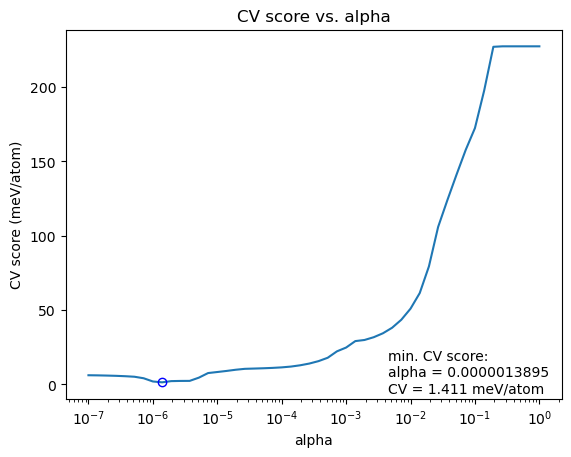

In [27]:
# scan different values of alpha and return the value of alpha that yields the lowest CV score
eva.set_fitting_scheme(fitting_scheme='l1')
alpha = eva.plot_CV(alpha_min=1E-7, alpha_max = 1.0, num_alpha = 50)

In [28]:
# set the alpha value with the one found above and fit data using it 
eva.set_fitting_scheme(fitting_scheme='l1', alpha=alpha)
eva.fit()

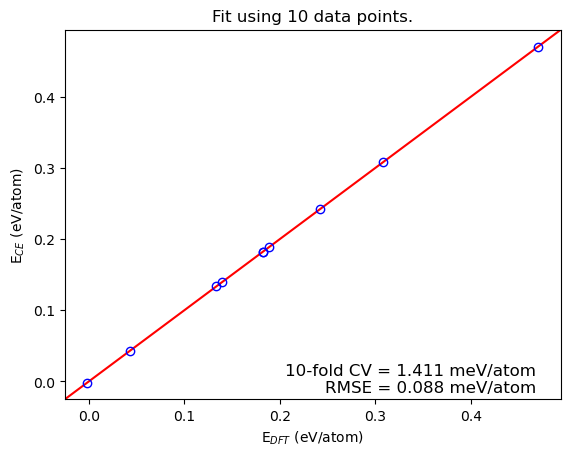

In [30]:
# plot the fit results 
fig = pp.plot_fit(eva)
plt.show()

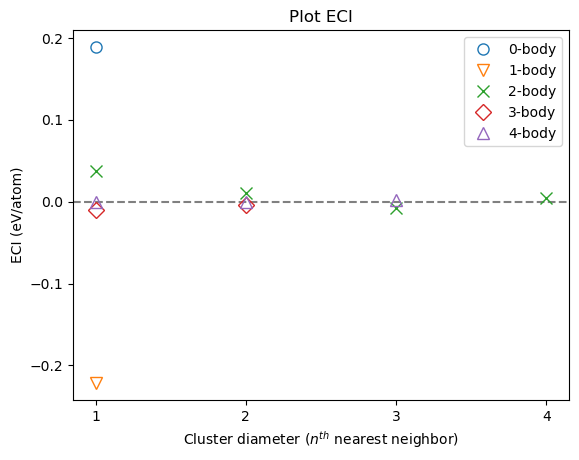

In [31]:
# plot the eci values
fig = pp.plot_eci(eva)
plt.show()


In [32]:
# save the dictionary containing the cluster names and their ECI's 
eva.save_eci(fname='eci_l1')

## Generating New Structures for Training 

Unlike in the 0 generation which was at random, Here we are going to generate new structures using the probe method. You can construct them from probing where to find the most different structures, or you can use ground-state structures predicted on the current CE model 

In [36]:
from clease import NewStructures 
ns = NewStructures(settings=settings, generation_number=1,struct_per_gen=25)
ns.generate_probe_structure()

Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Could not generate probe structure in 10 attempts.


MaxAttemptReachedError: Could not generate probe structure in 10 attempts.

Here now we can use the existing training data to generate a ground state, and now we can create new structures that are based on the CE model we have now. Check out the scripts in "Running calculations on generated structures" and "Evaluating hte CE Model" to see how the convex hull plot and the lastest CV score of model, CV score should be less than 5meV/atom 

In [37]:
# generate the ground states from the CE model
from ase.db import connect
import json

# get template with the cell size = 4x4x4
template = connect('aucu.db').get(id=17).toatoms()
# import dictionary containing cluster names and their ECIs
with open('eci_l1.json') as f:
    eci = json.load(f)

ns = NewStructures(settings, generation_number=2, struct_per_gen=10)
ns.generate_gs_structure(atoms=template, init_temp=2000,
                         final_temp=1, num_temp=10,
                         num_steps_per_temp=5000,
                         eci=eci, random_composition=True)

RuntimeError: Could not find 10 unique compositions using the provided Atoms object.

## Monte Carlo Sampling

In [1]:
from clease.settings import CEBulk, Concentration

conc = Concentration(basis_elements=[['Au', 'Cu']])
settings = CEBulk(crystalstructure='fcc',
                  a=3.8,
                  supercell_factor=27,
                  concentration=conc,
                  db_name="aucu.db",
                  max_cluster_dia=[6.0, 5.0])

In [2]:
# set the ECI values, which can be grabbed from a file like eci_l1.json 
eci = {'c0': -1.0, 'c1_0': 0.1, 'c2_d0000_0_00': -0.2}


In [3]:
# attach the calculator to the atoms object to allow us to create the MCMC model easily 
from clease.calculator import attach_calculator
atoms = settings.atoms.copy()*(5, 5, 5)
atoms = attach_calculator(settings, atoms=atoms, eci=eci)

In [4]:
# now insert a few Cu atoms to the system 
atoms[0].symbol = 'Cu'
atoms[1].symbol = 'Cu'
atoms[2].symbol = 'Cu'


In [5]:
pre_atoms = atoms.copy()
pre_cu_atoms = [atom for atom in pre_atoms if atom.symbol == 'Cu']
for atom in pre_cu_atoms:
    print(atom.position)

[0. 0. 0.]
[ 1.90000000e+00 -6.24498069e-17  1.90000000e+00]
[1.9 1.9 0. ]


In [6]:
# run the MC simulation
from clease.montecarlo import Montecarlo
T = 500 
mc = Montecarlo(atoms, T)
mc.run(steps=1000) # this should really be 1000 * number of atoms 

In [7]:
post_atoms = mc.atoms.copy()
cu_atoms = [atom for atom in post_atoms if atom.symbol == 'Cu']
for atom in cu_atoms:
    print(atom.position)

[24.7 11.4 20.9]
[26.6 11.4 22.8]
[26.6 13.3 20.9]


In [8]:
thermo = mc.get_thermodynamic_quantities()
print(thermo)

{'energy': -823.370666666671, 'heat_capacity': 0.001339811169092469, 'energy_var': 0.028863988583907485, 'temperature': 500, 'accept_rate': 0.494, 'n_mc_steps': 1000, 'Au_conc': 0.996, 'Cu_conc': 0.004, 'timestamp': '2024-03-29T16:03:08.343'}


In [47]:
# Monitoring the MC Run to see how things change 
from clease.montecarlo.observers import EnergyEvolution
obs = EnergyEvolution(mc)
mc.attach(obs, interval=100)
mc.run(steps=1000)
energies = obs.energies